In [6]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.9.1


In [3]:
# !pip install autokeras

In [5]:
# !pip install keras-tuner

In [7]:
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob #to walk through folder structure
from PIL import Image #image loading,resize
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
np.random.seed(42)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [3]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')

In [4]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [5]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [6]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [7]:
#Balance data.
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [8]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [9]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [10]:
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [11]:
SIZE=32
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/all_images/', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [12]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,data/all_images\ISIC_0026645.jpg,"[[[155, 118, 107], [162, 126, 118], [174, 140,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,data/all_images\ISIC_0025780.jpg,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,data/all_images\ISIC_0024450.jpg,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,data/all_images\ISIC_0027896.jpg,"[[[205, 149, 175], [207, 149, 169], [214, 158,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,data/all_images\ISIC_0029268.jpg,"[[[203, 174, 199], [205, 174, 197], [206, 175,..."


In [13]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

In [20]:
#Split to training and testing. Getting a very small dataset for training autokeras
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.9, random_state=42)

#Further split data into smaller size to get a small test dataset. 
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.1, random_state=42)

In [29]:
print("shape of training data {},_{}",x_train_auto.shape,y_train_auto.shape)

shape of training data {},_{} (350, 32, 32, 3) (350, 7)


In [30]:
print("shape of validationdata {},_{}",x_valid.shape,y_valid.shape)

shape of validationdata {},_{} (315, 32, 32, 3) (315, 7)


In [21]:
#Define classifier for autokeras. Here we check 15 different models, each model 25 epochs
clf = ak.ImageClassifier(max_trials=15) #MaxTrials - max. number of keras models to try
clf.fit(x_train_auto, y_train_auto, epochs=10) # while training default validation split is 0.2

Trial 15 Complete [00h 00m 09s]
val_loss: 1.4182049036026

Best val_loss So Far: 1.31146240234375
Total elapsed time: 02h 56m 12s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
11/11 [==============================] - 1s 84ms/step - loss: 2.0145 - accuracy: 0.1886
Epoch 2/10
11/11 [==============================] - 1s 84ms/step - loss: 1.8135 - accuracy: 0.2886
Epoch 3/10
11/11 [==============================] - 1s 86ms/step - loss: 1.6964 - accuracy: 0.3114
Epoch 4/10
11/11 [==============================] - 1s 85ms/step - loss: 1.6112 - accuracy: 0.3543
Epoch 5/10
11/11 [==============================] - 1s 85ms/step - loss: 1.4764 - accuracy: 0.4343
Epoch 6/10
11/11 [==============================] - 1s 85ms/step - loss: 1.4555 - accuracy: 0.4457
Epoch 7/10
11/11 [==============================] - 1s 85ms/step - loss: 1.3308 - accuracy: 0.5114
Epoch 8/10
11/11 [==============================] - 1s 85ms/step - loss: 1.2754 - accuracy: 0.5114
Epoch 9/10
11/11 [======================

2022-12-13 13:18:27.417880: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [22]:
_,acc = clf.evaluate(x_valid,y_valid)
print("accuracy=",(acc*100),"%")

10/10 [==============================] - 0s 24ms/step - loss: 1.4783 - accuracy: 0.4635
accuracy= 46.34920656681061 %


In [23]:
model = clf.export_model()

In [24]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        204864    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 64)         0     

In [26]:
model.save("models/autokeras_bestmodel.h5")

### Training best model on more training data 

In [5]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

NameError: name 'train_test_split' is not defined

In [15]:
x_train.shape

(2625, 32, 32, 3)

In [16]:
x_test.shape

(875, 32, 32, 3)

In [34]:
y_train.shape

(2625, 7)

In [35]:
y_test.shape

(875, 7)

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [37]:
batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50
165/165 - 8s - loss: 1.4991 - acc: 0.4328 - val_loss: 1.3576 - val_acc: 0.4903 - 8s/epoch - 46ms/step
Epoch 2/50
165/165 - 8s - loss: 1.3212 - acc: 0.5029 - val_loss: 1.1841 - val_acc: 0.5531 - 8s/epoch - 46ms/step
Epoch 3/50
165/165 - 8s - loss: 1.2242 - acc: 0.5425 - val_loss: 1.2352 - val_acc: 0.5611 - 8s/epoch - 46ms/step
Epoch 4/50
165/165 - 8s - loss: 1.1592 - acc: 0.5730 - val_loss: 1.0824 - val_acc: 0.5943 - 8s/epoch - 46ms/step
Epoch 5/50
165/165 - 8s - loss: 1.0737 - acc: 0.6053 - val_loss: 1.0022 - val_acc: 0.6480 - 8s/epoch - 45ms/step
Epoch 6/50
165/165 - 8s - loss: 1.0383 - acc: 0.6175 - val_loss: 1.0007 - val_acc: 0.6663 - 8s/epoch - 46ms/step
Epoch 7/50
165/165 - 8s - loss: 0.9554 - acc: 0.6457 - val_loss: 1.0552 - val_acc: 0.6286 - 8s/epoch - 46ms/step
Epoch 8/50
165/165 - 8s - loss: 0.9323 - acc: 0.6629 - val_loss: 0.9336 - val_acc: 0.6914 - 8s/epoch - 46ms/step
Epoch 9/50
165/165 - 8s - loss: 0.8748 - acc: 0.6659 - val_loss: 0.9267 - val_acc: 0.6686 - 8s/e

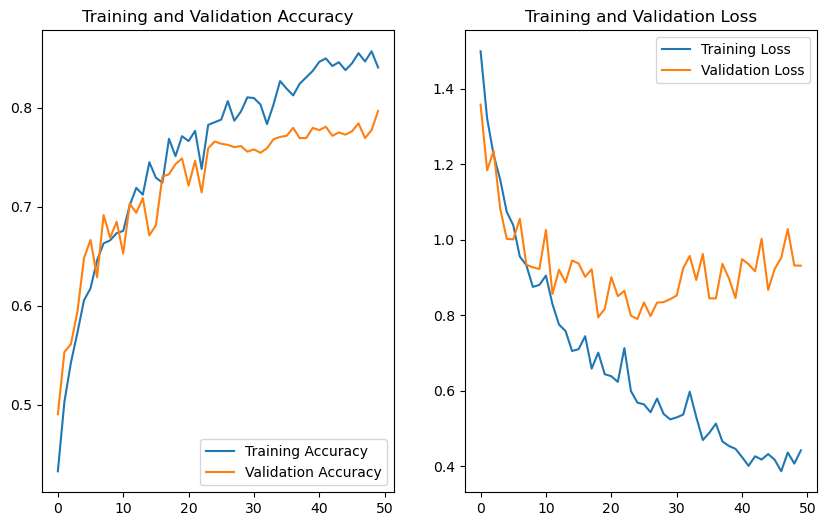

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 1s 23ms/step - loss: 0.9311 - acc: 0.7966
Test accuracy: 0.7965714335441589


In [48]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=10,min_delta=0.0001)
extend_epochs =25
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(x_train, y_train,
                  initial_epoch=history.epoch[-1],
                epochs=total_epochs,
                batch_size = batch_size,
                validation_data=(x_test, y_test),
                verbose=2,callbacks=[es])

Epoch 50/74
165/165 - 8s - loss: 0.3750 - acc: 0.8697 - val_loss: 1.0053 - val_acc: 0.7829 - 8s/epoch - 46ms/step
Epoch 51/74
165/165 - 8s - loss: 0.5006 - acc: 0.8175 - val_loss: 1.1377 - val_acc: 0.7760 - 8s/epoch - 46ms/step
Epoch 52/74
165/165 - 8s - loss: 0.3903 - acc: 0.8575 - val_loss: 1.0273 - val_acc: 0.7886 - 8s/epoch - 46ms/step
Epoch 53/74
165/165 - 8s - loss: 0.3510 - acc: 0.8720 - val_loss: 0.9090 - val_acc: 0.7817 - 8s/epoch - 46ms/step
Epoch 54/74
165/165 - 8s - loss: 0.3323 - acc: 0.8800 - val_loss: 1.0077 - val_acc: 0.7931 - 8s/epoch - 47ms/step
Epoch 55/74
165/165 - 8s - loss: 0.3185 - acc: 0.8888 - val_loss: 1.0213 - val_acc: 0.7840 - 8s/epoch - 47ms/step
Epoch 56/74
165/165 - 8s - loss: 0.3176 - acc: 0.8861 - val_loss: 1.0027 - val_acc: 0.7966 - 8s/epoch - 47ms/step
Epoch 57/74
165/165 - 8s - loss: 0.3706 - acc: 0.8712 - val_loss: 1.0560 - val_acc: 0.7909 - 8s/epoch - 47ms/step
Epoch 58/74
165/165 - 8s - loss: 0.3050 - acc: 0.8971 - val_loss: 1.1870 - val_acc: 0.76

In [49]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 1s 23ms/step - loss: 1.2148 - acc: 0.7851
Test accuracy: 0.7851428389549255


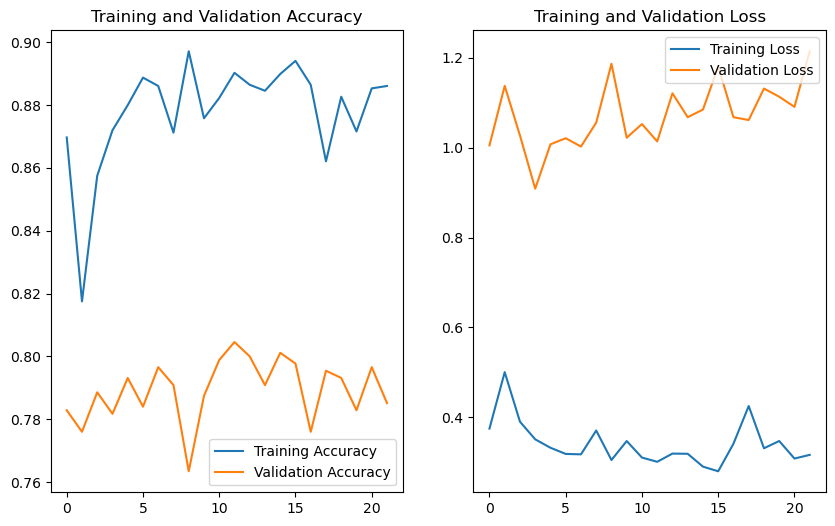

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
model.save("models/autokeras_model_79acc.h5")